--- Cleaned and Aggregated Sales Data Head ---
        Date  Weekly_Sales
0 2010-02-05   49750740.50
1 2010-02-12   48336677.63
2 2010-02-19   48276993.78
3 2010-02-26   43968571.13
4 2010-03-05   46871470.30


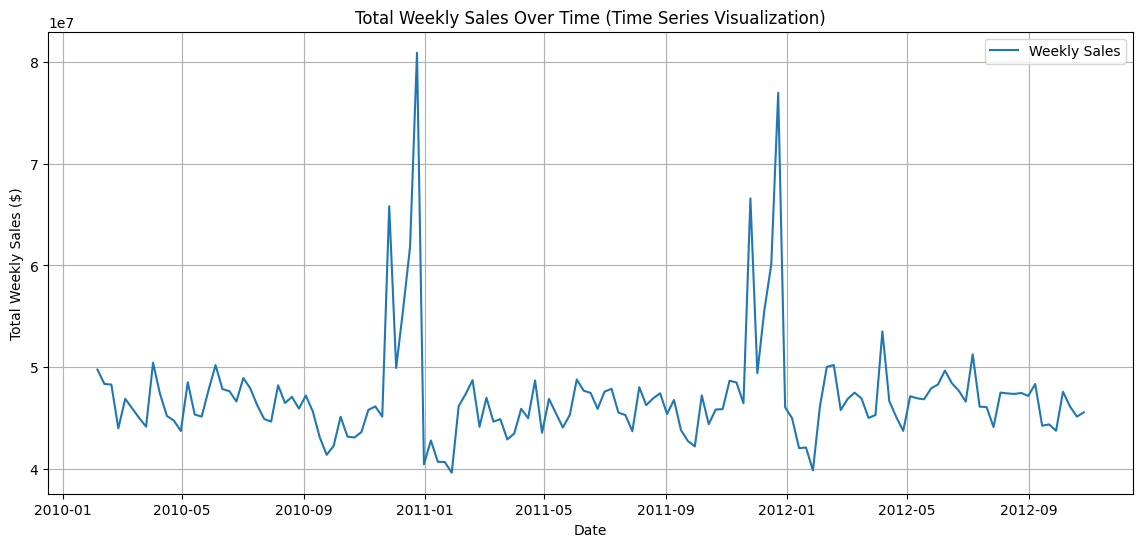


--- Sales Data Ready for Feature Engineering ---


In [2]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Load Data ---
# Make sure your main sales file (e.g., 'train.csv') is uploaded
try:
    # Adjust the filename if yours is different (e.g., 'Walmart_Store_Sales.csv')
    df = pd.read_csv('Walmart.csv')
except FileNotFoundError:
    print("Error: Sales data file not found. Please upload 'train.csv' or adjust the filename.")
    exit()

# --- 2. Initial Cleanup and Date Conversion ---

# Convert the 'Date' column to a proper datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Focus on the total sales for the entire company (sum across stores/departments)
# For simplicity, we aggregate the weekly sales by date.
sales_data = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Check for missing values (since time series models cannot handle gaps)
if sales_data['Weekly_Sales'].isnull().any():
    # Fill any missing sales with the value from the previous week (Forward Fill)
    sales_data['Weekly_Sales'] = sales_data['Weekly_Sales'].fillna(method='ffill')

print("--- Cleaned and Aggregated Sales Data Head ---")
print(sales_data.head())

# --- 3. Initial Visualization ---
plt.figure(figsize=(14, 6))
plt.plot(sales_data['Date'], sales_data['Weekly_Sales'], label='Weekly Sales')
plt.title('Total Weekly Sales Over Time (Time Series Visualization)')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales ($)')
plt.legend()
plt.grid(True)
plt.show()

# Set the date as the index for time series features later
sales_data = sales_data.set_index('Date')
print("\n--- Sales Data Ready for Feature Engineering ---")

In [3]:
# --- 1. Extract Time Features ---

# Extract month, week of year, and year
sales_data['Year'] = sales_data.index.year
sales_data['Month'] = sales_data.index.month
sales_data['Week'] = sales_data.index.isocalendar().week.astype(int)
sales_data['DayOfWeek'] = sales_data.index.dayofweek

# --- 2. Create Lag Features ---

# Create a feature for sales from the previous week (Lag 1)
# This is the single most important predictor in a sales forecast
sales_data['Sales_Lag_1'] = sales_data['Weekly_Sales'].shift(1)

# Create a feature for sales from the same week one year prior (Lag 52)
sales_data['Sales_Lag_52'] = sales_data['Weekly_Sales'].shift(52)

# Drop the first row since it will contain NaN values after the shift operations
sales_data = sales_data.dropna()

print("\n--- Sales Data with Time & Lag Features Head ---")
print(sales_data.head())


--- Sales Data with Time & Lag Features Head ---
            Weekly_Sales  Year  Month  Week  DayOfWeek  Sales_Lag_1  \
Date                                                                  
2011-02-04   46153111.12  2011      2     5          4  39599852.99   
2011-02-11   47336192.79  2011      2     6          4  46153111.12   
2011-02-18   48716164.12  2011      2     7          4  47336192.79   
2011-02-25   44125859.84  2011      2     8          4  48716164.12   
2011-03-04   46980603.74  2011      3     9          4  44125859.84   

            Sales_Lag_52  
Date                      
2011-02-04   49750740.50  
2011-02-11   48336677.63  
2011-02-18   48276993.78  
2011-02-25   43968571.13  
2011-03-04   46871470.30  


In [4]:
# Select features (X) and target (y)
X = sales_data[['Year', 'Month', 'Week', 'DayOfWeek', 'Sales_Lag_1', 'Sales_Lag_52']]
y = sales_data['Weekly_Sales']

# Determine the split point (e.g., 80% for training)
split_point = int(len(X) * 0.8)

# Time-aware split: Train on the first 80%, Test on the last 20%
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]

X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

print(f"Training set size: {len(X_train)} weeks")
print(f"Test set size: {len(X_test)} weeks")

# --- 3. Train and Predict ---

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

Training set size: 72 weeks
Test set size: 19 weeks



--- Model Evaluation (Test Set) ---
Root Mean Squared Error (RMSE): $2,264,107.18
Mean Absolute Error (MAE): $2,104,847.19
R-squared (R2 Score): -0.6564


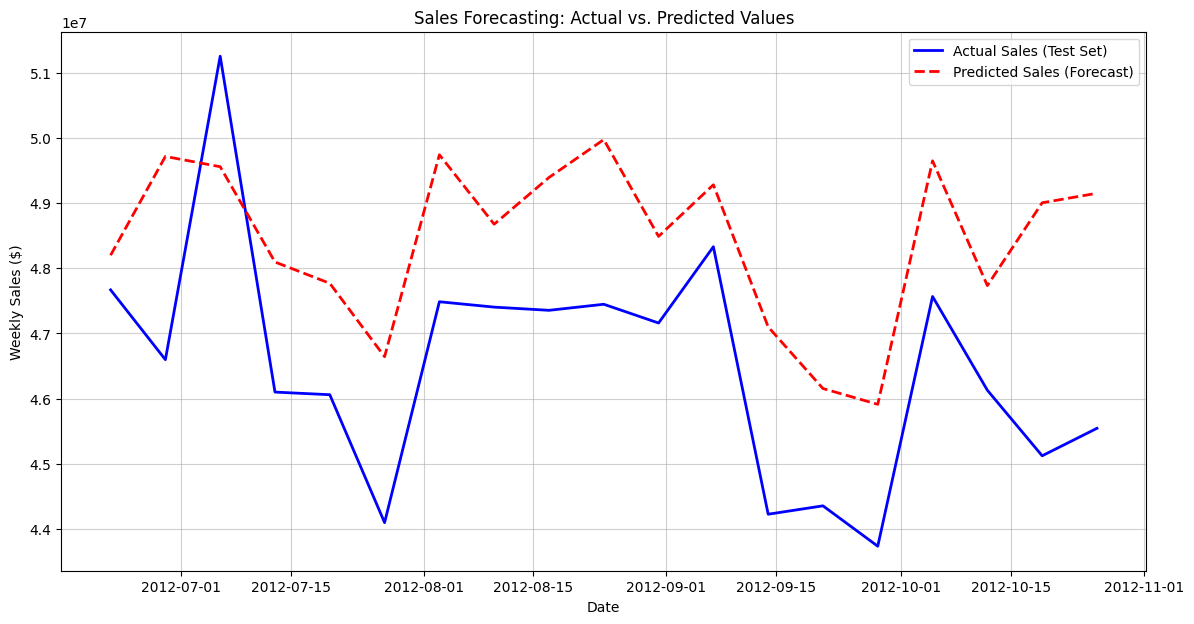

In [5]:
# --- 1. Calculate Metrics ---

# Evaluate the model using common regression metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation (Test Set) ---")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"R-squared (R2 Score): {r2:.4f}")

# --- 2. Visualization ---

# Create a DataFrame for easy plotting
forecast_df = pd.DataFrame({'Actual Sales': y_test, 'Predicted Sales': y_pred}, index=y_test.index)

plt.figure(figsize=(14, 7))
plt.plot(forecast_df.index, forecast_df['Actual Sales'], label='Actual Sales (Test Set)', color='blue', linewidth=2)
plt.plot(forecast_df.index, forecast_df['Predicted Sales'], label='Predicted Sales (Forecast)', color='red', linestyle='--', linewidth=2)
plt.title('Sales Forecasting: Actual vs. Predicted Values')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

In [6]:
# Import the XGBoost Regressor
import xgboost as xgb

# Initialize and train the XGBoost model
# We set random_state for reproducible results and n_estimators for a strong model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)


--- XGBoost Model Evaluation (Advanced) ---
Root Mean Squared Error (RMSE): $1,992,367.59
Mean Absolute Error (MAE): $1,562,365.44
R-squared (R2 Score): -0.2827


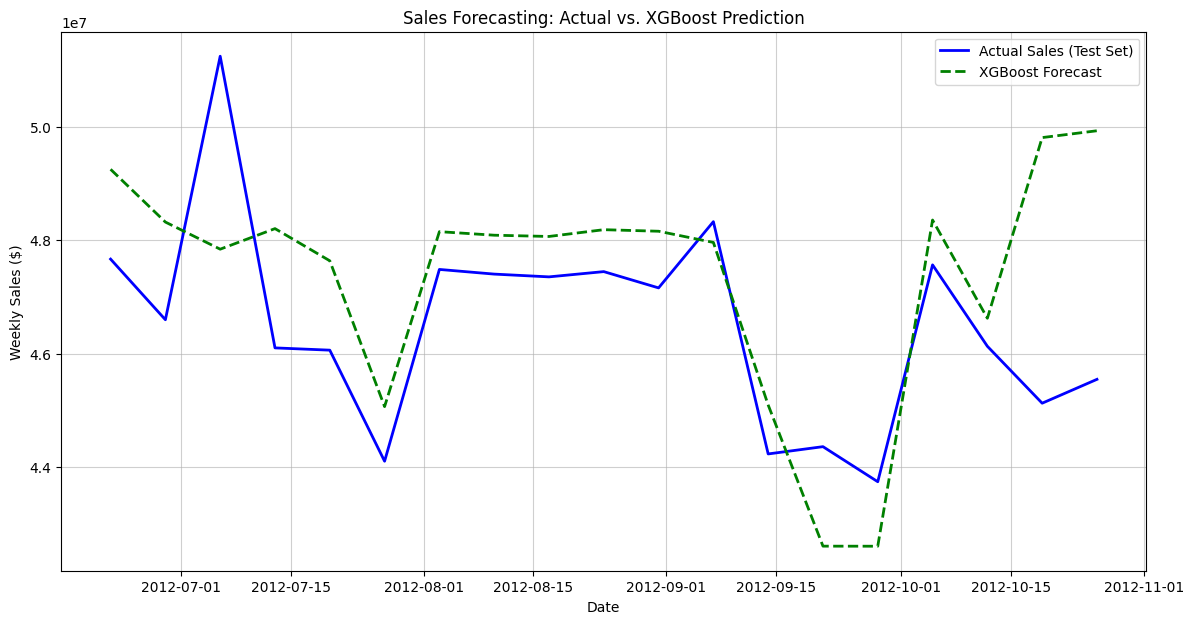


--- XGBoost Feature Importance ---
Sales_Lag_52    0.814849
Year            0.089171
Week            0.042589
Month           0.030125
Sales_Lag_1     0.023265
DayOfWeek       0.000000
dtype: float32


In [7]:
# --- 1. Calculate Metrics for XGBoost ---
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n--- XGBoost Model Evaluation (Advanced) ---")
print(f"Root Mean Squared Error (RMSE): ${rmse_xgb:,.2f}")
print(f"Mean Absolute Error (MAE): ${mae_xgb:,.2f}")
print(f"R-squared (R2 Score): {r2_xgb:.4f}")

# --- 2. Visualization (Actual vs. XGBoost Forecast) ---
# Create a DataFrame for easy plotting
forecast_xgb_df = pd.DataFrame({'Actual Sales': y_test, 'Predicted Sales (XGBoost)': y_pred_xgb}, index=y_test.index)

plt.figure(figsize=(14, 7))
plt.plot(forecast_xgb_df.index, forecast_xgb_df['Actual Sales'], label='Actual Sales (Test Set)', color='blue', linewidth=2)
plt.plot(forecast_xgb_df.index, forecast_xgb_df['Predicted Sales (XGBoost)'], label='XGBoost Forecast', color='green', linestyle='--', linewidth=2)
plt.title('Sales Forecasting: Actual vs. XGBoost Prediction')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

# --- 3. Optional: Feature Importance ---
# See which features the model found most useful
print("\n--- XGBoost Feature Importance ---")
feature_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importance)

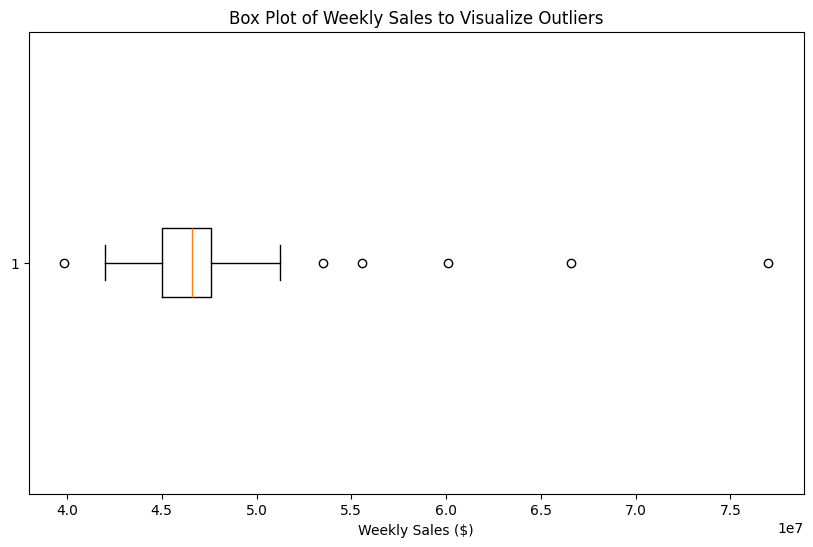


--- Outlier Identification (IQR Method) ---
Q1 (25th percentile): $45,033,162.12
Q3 (75th percentile): $47,623,402.23
Upper Outlier Boundary (Q3 + 1.5*IQR): $51,508,762.41
Total number of outliers detected: 6

Dates and Sales of Detected Outliers:
            Weekly_Sales
Date                    
2011-12-23   76998241.31
2011-11-25   66593605.26
2011-12-16   60085695.94
2011-12-09   55561147.70
2012-04-06   53502315.87
2012-01-27   39834974.67


In [8]:
# --- 1. Outlier Visualization (Box Plot) ---

plt.figure(figsize=(10, 6))
# We plot the aggregated 'Weekly_Sales' data you used for training
plt.boxplot(sales_data['Weekly_Sales'], vert=False)
plt.title('Box Plot of Weekly Sales to Visualize Outliers')
plt.xlabel('Weekly Sales ($)')
plt.show()


# --- 2. Statistical Outlier Detection (IQR Method) ---

Q1 = sales_data['Weekly_Sales'].quantile(0.25)
Q3 = sales_data['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier boundary (1.5 * IQR above Q3)
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Identify the actual outlier data points
outliers = sales_data[(sales_data['Weekly_Sales'] > upper_bound) | (sales_data['Weekly_Sales'] < lower_bound)]

print("\n--- Outlier Identification (IQR Method) ---")
print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"Upper Outlier Boundary (Q3 + 1.5*IQR): ${upper_bound:,.2f}")
print(f"Total number of outliers detected: {len(outliers)}")

if not outliers.empty:
    print("\nDates and Sales of Detected Outliers:")
    print(outliers[['Weekly_Sales']].sort_values(by='Weekly_Sales', ascending=False))
else:
    print("\nNo significant outliers detected outside the 1.5*IQR range.")